In [1]:
print("let's do this")

let's do this


I believe that we have
# *Gotten Jupyter Working*

### **We are creating a betting app, that hopefully helps the user place smarter bets. How do we do this?**
###### let's think ##

### Bets are based on what? ###
- Team stats (+/- OU, ML)
- Player Stats (Pts, Reb, Ast)
- Game-based Stats (First to X, First-half)
- Stat Combinations (Pts+Reb, Double-Double)

We will need a way to:
1. Intake stats from sources (Web, CSV, SQL, etc.)
2. Relational db of players with stats
3. Analyze via functions

Keeping simplicity in mind, the easiest functionalist we can code is accessing a single player's stats (we'll use points) for the current 2022 NBA Season.

CSV's would be an easy choice, but it will be outdated as the season progresses. 
We could manually code a web-scraper, but this would require a long time investment and time is valuable.
API commands to pull from a source are a good compromise.

For now, let's deal with CSV's.

In [2]:
import pandas as pd # Module Importing
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/Users/kareemtaha/Downloads/2022-2023 NBA Player Stats - Regular.csv', sep=";", index_col=0, encoding = 'latin') # the csv uses colons (;) instead of commas (,) to separate values
#df = df.drop(columns="Rk") # drop unnecessary Rk column. Useful if we used player names as our index, but that complicates functions later, so we just leave RK.
df

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,
1,Precious Achiuwa,C,23,TOR,12,0,20.4,3.0,7.7,0.391,...,0.848,2.0,5.0,7.0,1.3,0.2,0.6,1.3,1.6,8.8
2,Steven Adams,C,29,MEM,15,15,26.0,2.9,4.7,0.629,...,0.257,4.9,5.8,10.7,2.4,0.7,1.1,2.3,2.7,6.5
3,Bam Adebayo,C,25,MIA,14,14,35.0,7.4,14.0,0.531,...,0.855,2.4,6.7,9.1,3.4,1.2,0.8,3.6,3.4,19.1
4,Ochai Agbaji,SG,22,UTA,6,0,11.2,1.3,3.2,0.421,...,0.571,0.7,1.0,1.7,0.2,0.0,0.0,0.0,1.0,3.3
5,Santi Aldama,PF,22,MEM,16,14,27.3,3.8,8.1,0.465,...,0.679,1.8,4.5,6.3,0.9,0.9,1.1,0.6,2.7,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,Delon Wright,PG,30,WAS,4,0,22.8,2.5,6.0,0.417,...,0.600,1.0,1.5,2.5,3.3,2.8,1.0,1.0,1.3,6.5
461,McKinley Wright IV,PG,24,DAL,1,0,5.0,1.0,4.0,0.250,...,0.000,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0
462,Thaddeus Young,PF,34,TOR,14,4,16.4,2.3,4.1,0.561,...,0.800,1.8,2.0,3.8,1.6,1.1,0.1,0.6,1.6,5.2


Great! We have our players this season, their teams, and their stats. Let's return one player.

In [4]:
df.query('Player=="Marcus Smart"') # via query
df[df['Player'] == 'Marcus Smart'] # via series (same code)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,
391,Marcus Smart,PG,28,BOS,14,14,32.7,4.1,9.7,0.419,...,0.828,0.3,2.9,3.2,7.1,1.1,0.3,1.6,3.1,11.4


In [5]:
All_Stats = df.columns.values.tolist()
Qual_Stats = ["Pos", "Tm"]
Quant_Stats = ["Age", "G", "GS", "MP", "PTS", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P","2PA","2P%","eFG%","FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV","PF"]

In [6]:
#Input:
#d- dataframe df- data - (name inclusive)
#players - list (str) - player(s)
#stats - list (str) - stats to visualize from d (for the default stats set (quant_stats), we assign stats to a copy of it to not add "Player" to quant_stats forever)
def Get_Player_df(d, player, stats = Quant_Stats.copy(), type="Series"):
    if stats != None: d = d[["Player"] + stats]
    if type == "Query": return d.query(f'Player=="{player}"')
    return d.loc[d["Player"] == player]

Get_Player_df(df, "Damian Lillard")

,Player,Age,G,GS,MP,PTS,FG,FGA,FG%,3P,...,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF
Rk,,,,,,,,,,,,,,,,,,,,,
253,Damian Lillard,32,11,11,35.2,26.3,7.6,18.1,0.422,3.4,...,8.7,0.875,0.9,3.4,4.3,7.0,0.5,0.3,3.8,1.6


In [7]:
#Input:
#d- dataframe df- data - (name inclusive)
#players - list (str) - player(s)
#stats - list (str) of stats to visualize from d
def Get_Players_df(d, player1, player2, stats = Quant_Stats.copy()):
    if stats != None: #User specifies certain stats (non-default)
        try: assert "Player" in stats #Makes sure that when we shrink the df to those stats, we don't accidentally remove the Player Name col (needed for compares)
        except AssertionError: stats.append("Player") 
        d = d[stats]

    return d[d['Player'].isin([player1, player2])]

Get_Players_df(df, "Damian Lillard", "Stephen Curry")

,Age,G,GS,MP,PTS,FG,FGA,FG%,3P,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,Player
Rk,,,,,,,,,,,,,,,,,,,,,
95,34,15,15,34.6,32.2,10.9,20.6,0.528,5.1,11.6,...,0.909,0.6,6.1,6.7,6.6,1.1,0.1,2.7,2.0,Stephen Curry
253,32,11,11,35.2,26.3,7.6,18.1,0.422,3.4,10.1,...,0.875,0.9,3.4,4.3,7.0,0.5,0.3,3.8,1.6,Damian Lillard


We can now compare two players current league stats. Neat.

Next, let's see some visuals since I am tired of seeing words and text.

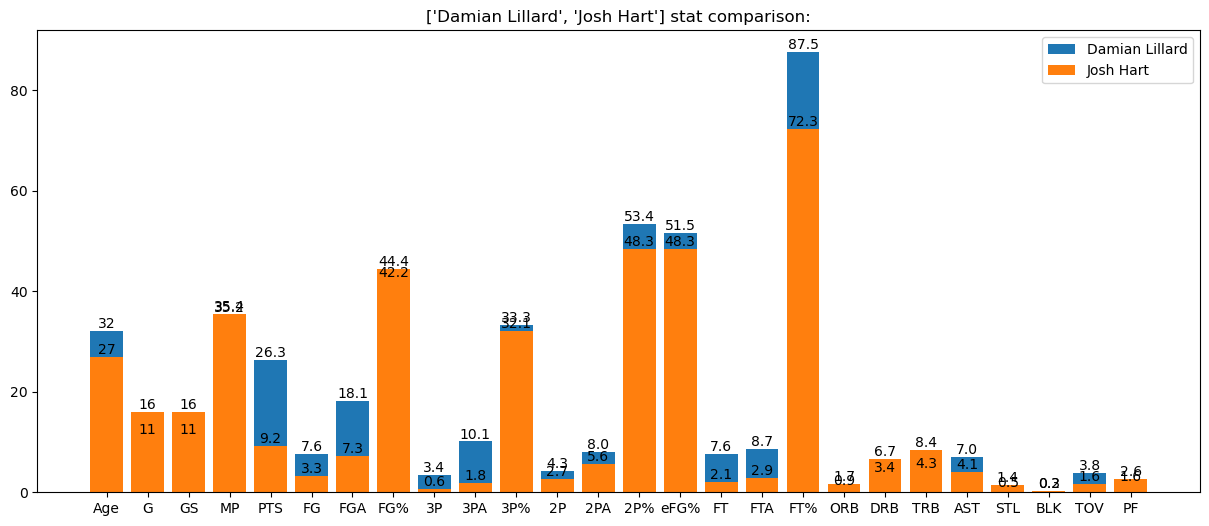

In [8]:
#   Input:
#   d- dataframe df- data - (name inclusive)
#   players - list (str) - player(s)
#   stats - list (str) of stats to visualize from d
#   to_list - bool - returns a list of the visualized stats. If multiple players, returns a 2D list. 
#   if 2D, each list indexes (e.g. Visualize_Stats()[0] vs Visualize_Stats[1]) players and sub-indexes (Vis_S[0][0] vs Vis_S[0][1]) are different stats for that player

def Visualize_Stats(d, players, stats = Quant_Stats, to_list = False, stacked_bar = False):

    try: assert len(stats) > 0                 # Stats Setup - Ensure we don't accidentally remove the Player Name col (needed for compares) {
    except AssertionError: stats.append("PTS") # .. 
    d = d[["Player"] + stats]                  # .. - shrink to stats (retain player to search their stats later)
    return_stats = []                          # ..
    num_players = len(players)                 # .. } Stats Setup
    if(num_players == 1):           # CASE: 1 PLAYER
        plt.figure(figsize=(15,6))                          # Graph Setup
        plt.title(f"{players[0]}'s stats:")                 # Graph Setup
        player_stats = []                                   # Player Stats Setup
        stat_df = Get_Player_df(d, players[0], stats=stats) # Player Stats Setup
        for stat in stats:                      # Stats -> (Usable) Data
            value = stat_df[stat].iat[0]        # Stats -> Data
            if "%" in stat: value *= 100        # Stats -> Data
            player_stats.append(round(value,2)) # Stats -> Data
        b = plt.bar(x=stats, height=player_stats) # Display Data
        plt.bar_label(b, player_stats)            # Display Data
        if to_list: return player_stats           # (Optional) - Return [Data]   
    elif stacked_bar:               # CASE: 2+ PLAYER, STACKED GRAPH
        num_stats = len(stats)             # Stats Setup
        plt.figure(figsize=(15,6))         # Graph Setup
        plt.title(f"{players} stat comparison:")   # Graph Setup
        for player in players:                              # Stats Setup
            player_stats = []                               # Stats Setup
            stat_df = Get_Player_df(d, player, stats=stats) # Stats Setup
            for stat in stats:                              # Stats -> Data
                value = stat_df[stat].iat[0]                # Stats -> Data
                if "%" in stat: value *= 100                # Stats -> Data
                if type(value) != str: value = round(value,2) # Stats -> Data
                player_stats.append(value) # Stats -> Data
            #if !to_list: (complete this if block if you want to_list to not also graph stats
            b = plt.bar(stats, player_stats)
            plt.bar_label(b, player_stats)
            return_stats.append([player] + player_stats)
    else:
        fig, ax = plt.subplots(num_players, figsize=(15,(3.5*num_players)))
        for player in players:
            ax[num_players-1].set_title(f"{player}'s stats:")
            player_stats = []            
            stat_df = Get_Player_df(d, player, stats=stats)
            for stat in stats:
                value = stat_df[stat].iat[0]
                if "%" in stat: value *= 100
                if type(value) != str: value = round(value,2)
                player_stats.append(value)
            #if !to_list: (complete this if block if you want to_list to not also graph stats
            b = ax[num_players-1].bar(x=stats, height=player_stats)
            ax[num_players-1].bar_label(b, player_stats)
            num_players-=1 #)
            return_stats.append([player] + player_stats)
    plt.legend(players)
    if to_list: return return_stats

#Visualize_Stats(df, players = ["Damian Lillard"])
#Visualize_Stats(df, players = ["Damian Lillard"], to_list=True)
Visualize_Stats(df, players = ["Damian Lillard", "Josh Hart"], stats=Quant_Stats, stacked_bar=True)
#f = Visualize_Stats(df, players = ["Damian Lillard", "Stephen Curry"], to_list=True)
#f[0]


We can now visualize a player's stats and compare them to someone else's.
## What do we do now?

###### Great question

What values do we want to extrapolate?

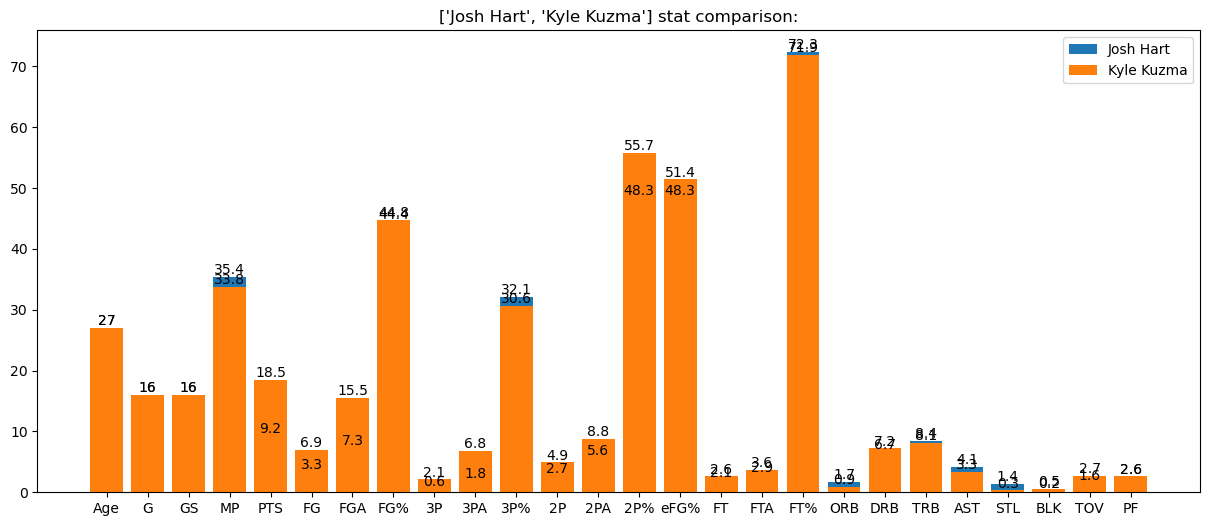

In [25]:
def Compare_Players(d, stacked_bar = False):
    selected = []
    players = d['Player'].values
    player = input("Which player's stats would you like to see? (' ' to terminate)")

    while player in players:
        selected.append(player)
        player = input("Which player's stats would you like to see? (' ' to terminate)")
    
    if len(selected) > 0: Visualize_Stats(d, selected, stacked_bar = stacked_bar)
    else: print("No players given!")

Compare_Players(df, True)




In [33]:
Functions = [
            Get_Player_df, 
            Get_Players_df, 
            Visualize_Stats, 
            Compare_Players
            ]

Not bad, but now we need to work with more insightful data than season averages if we want to do advanced computations. Let's get game-by-game info's for players (We'll use LeBron's stats from (https://www.basketball-reference.com/players/j/jamesle01/gamelog/2023)).

In [78]:
lebron_2023_html = pd.read_html("https://www.basketball-reference.com/players/j/jamesle01/gamelog/2023#pgl_basic", match="Regular Season")
lebron_2023_df = lebron_2023_html[0].copy()
lebron_2023_df


,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1.0,2022-10-18,37-292,LAL,@,GSW,L (-14),1,35:12,...,10,15,8,0,0,5,2,31,23.9,-10
1,2,2.0,2022-10-20,37-294,LAL,NaN,LAC,L (-6),1,36:40,...,8,10,6,1,2,2,3,20,17.3,-1
2,3,3.0,2022-10-23,37-297,LAL,NaN,POR,L (-2),1,37:43,...,7,8,8,2,2,4,3,31,26.2,+2
3,4,4.0,2022-10-26,37-300,LAL,@,DEN,L (-11),1,35:18,...,5,7,9,1,0,8,1,19,8.9,-7
4,5,5.0,2022-10-28,37-302,LAL,@,MIN,L (-9),1,37:27,...,4,7,5,4,0,3,2,28,21.8,-13
5,6,6.0,2022-10-30,37-304,LAL,NaN,DEN,W (+11),1,34:42,...,6,6,8,1,0,3,1,26,19.2,-1
6,7,7.0,2022-11-02,37-307,LAL,NaN,NOP,W (+3),1,39:43,...,10,10,8,0,2,2,3,20,13.5,+5
7,8,8.0,2022-11-04,37-309,LAL,NaN,UTA,L (-14),1,34:09,...,8,10,8,0,1,3,3,17,11.6,-11
8,9,9.0,2022-11-06,37-311,LAL,NaN,CLE,L (-14),1,33:49,...,5,7,4,0,0,1,0,27,19.6,-8
9,10,NaN,2022-11-07,37-312,LAL,@,UTA,L (-23),Inactive,Inactive,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive


In [80]:
lebron_2023_df = lebron_2023_html[0].copy()
lebron_2023_df.rename(columns = {'Unnamed: 5':'Away', 'Unnamed: 7': 'Result'}, inplace = True) # Rename columns properly
lebron_2023_df.set_index('Rk', inplace = True) # Set the Rk number (team game) as the index
lebron_2023_df['Away'].mask(lebron_2023_df['Away'] == '@', True, inplace=True) ; lebron_2023_df['Away'] = lebron_2023_df['Away'].fillna(False) # replace values in away column with bool
lebron_2023_df.dropna(subset=['G']) # drop unplayed games


,G,Date,Age,Tm,Away,Opp,Result,GS,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
Rk,,,,,,,,,,,,,,,,,,,,,
1,1.0,2022-10-18,37-292,LAL,True,GSW,L (-14),1,35:12,12,...,10,15,8,0,0,5,2,31,23.9,-10
2,2.0,2022-10-20,37-294,LAL,False,LAC,L (-6),1,36:40,7,...,8,10,6,1,2,2,3,20,17.3,-1
3,3.0,2022-10-23,37-297,LAL,False,POR,L (-2),1,37:43,12,...,7,8,8,2,2,4,3,31,26.2,+2
4,4.0,2022-10-26,37-300,LAL,True,DEN,L (-11),1,35:18,8,...,5,7,9,1,0,8,1,19,8.9,-7
5,5.0,2022-10-28,37-302,LAL,True,MIN,L (-9),1,37:27,10,...,4,7,5,4,0,3,2,28,21.8,-13
6,6.0,2022-10-30,37-304,LAL,False,DEN,W (+11),1,34:42,10,...,6,6,8,1,0,3,1,26,19.2,-1
7,7.0,2022-11-02,37-307,LAL,False,NOP,W (+3),1,39:43,9,...,10,10,8,0,2,2,3,20,13.5,+5
8,8.0,2022-11-04,37-309,LAL,False,UTA,L (-14),1,34:09,7,...,8,10,8,0,1,3,3,17,11.6,-11
9,9.0,2022-11-06,37-311,LAL,False,CLE,L (-14),1,33:49,13,...,5,7,4,0,0,1,0,27,19.6,-8


And the same for career stats.

In [64]:
lebron_career_html = pd.read_html("https://www.basketball-reference.com/players/j/jamesle01.html#per_game")
lebron_career_df = lebron_career_html[0].copy()
lebron_career_df

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2003-04,19.0,CLE,NBA,SG,79.0,79.0,39.5,7.9,18.9,...,0.754,1.3,4.2,5.5,5.9,1.6,0.7,3.5,1.9,20.9
1,2004-05,20.0,CLE,NBA,SF,80.0,80.0,42.4,9.9,21.1,...,0.750,1.4,6.0,7.4,7.2,2.2,0.7,3.3,1.8,27.2
2,2005-06,21.0,CLE,NBA,SF,79.0,79.0,42.5,11.1,23.1,...,0.738,0.9,6.1,7.0,6.6,1.6,0.8,3.3,2.3,31.4
3,2006-07,22.0,CLE,NBA,SF,78.0,78.0,40.9,9.9,20.8,...,0.698,1.1,5.7,6.7,6.0,1.6,0.7,3.2,2.2,27.3
4,2007-08,23.0,CLE,NBA,SF,75.0,74.0,40.4,10.6,21.9,...,0.712,1.8,6.1,7.9,7.2,1.8,1.1,3.4,2.2,30.0
5,2008-09,24.0,CLE,NBA,SF,81.0,81.0,37.7,9.7,19.9,...,0.780,1.3,6.3,7.6,7.2,1.7,1.1,3.0,1.7,28.4
6,2009-10,25.0,CLE,NBA,SF,76.0,76.0,39.0,10.1,20.1,...,0.767,0.9,6.4,7.3,8.6,1.6,1.0,3.4,1.6,29.7
7,2010-11,26.0,MIA,NBA,SF,79.0,79.0,38.8,9.6,18.8,...,0.759,1.0,6.5,7.5,7.0,1.6,0.6,3.6,2.1,26.7
8,2011-12,27.0,MIA,NBA,SF,62.0,62.0,37.5,10.0,18.9,...,0.771,1.5,6.4,7.9,6.2,1.9,0.8,3.4,1.5,27.1
9,2012-13,28.0,MIA,NBA,PF,76.0,76.0,37.9,10.1,17.8,...,0.753,1.3,6.8,8.0,7.3,1.7,0.9,3.0,1.4,26.8


We need to get the years that LeBron has played, so we know which years to look up his per-game stats. We will extend this to every player.

In [95]:
lebron_career_df = lebron_career_html[0].copy()
lebron_career_df.dropna(subset=['Age'], inplace=True) # drop unplayed games
lebron_seasons = lebron_career_df['Season'].apply(lambda x: int(x[0:2] + x[5:7])).values # get the seasons he played

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])